# Analyze DLCC results

This notebook consists of analyzing results from DLCC experiments obtained with the notebook `run_dlcc.ipynb` and stored in `resources`. Images and tables from this notebook were included in the thesis paper.

Before running this notebook, move it to the `dlcc_evaluation_framework` folder and make sure that:

1. There is a `results` folder with at least the file `tc_collection_results.csv` 

2. An `assets` folder is created to store the images

In [1]:
import pandas as pd
from scipy.stats import binomtest

In [2]:
df = pd.read_csv("results/tc_collection_results.csv", decimal=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19800 entries, 0 to 19799
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TC Collection       19800 non-null  object 
 1   Size Group          19800 non-null  int64  
 2   Vector Name         19800 non-null  object 
 3   Classifier          19800 non-null  object 
 4   AVG Accuracy        19800 non-null  float64
 5   AVG # missing URLs  19800 non-null  float64
 6   Vector Path         19800 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.1+ MB


In [3]:
df["coverage"] = 1 - df["AVG # missing URLs"] / df["Size Group"]

df["coverage"].describe()

count    19800.000000
mean         0.986981
std          0.032381
min          0.791000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: coverage, dtype: float64

In [4]:
def get_embedding_type(test_name_short):
    breakdown = test_name_short.split('-')
    
    embedding_type = '-'.join(breakdown[0:-2])
    
    if embedding_type.startswith("non-rdf2vec-"):
        return embedding_type.replace("non-rdf2vec-", "")
    
    else:
        return str.upper(embedding_type).replace("RDF2VEC-", "RDF2vec$_{") + "}$"

def get_embedding_variant(test_name_short):
    breakdown = test_name_short.split('-')
    
    return  breakdown[-1].replace("autoencoded", "auto") + "-" + breakdown[-2]

df['embedding_type'] = df['Vector Name'].apply(get_embedding_type)
df['embedding_variant'] = df['Vector Name'].apply(get_embedding_variant)

print(df['embedding_type'].unique())
print(df['embedding_variant'].unique())

['RDF2vec$_{SG-OA}$' 'RDF2vec$_{CBOW-OA}$' 'RDF2vec$_{CBOW}$' 'TransR'
 'TransE-L2' 'TransE-L1' 'RotatE' 'RESCAL' 'DistMult' 'ComplEx'
 'RDF2vec$_{SG}$']
['auto-512' 'auto-256' 'original-200' 'avgbin-200' 'auto-128']


In [5]:
pd.pivot_table(
    df,
    values="coverage", 
    index=["TC Collection", "Size Group"],
    columns=["embedding_type"],
    aggfunc='mean',
)

embedding_type            ComplEx  DistMult  RDF2vec$_{CBOW-OA}$  \
TC Collection Size Group                                           
tc01          50              1.0       1.0             0.884000   
              500             1.0       1.0             0.898800   
              5000            1.0       1.0             0.913080   
tc01_hard     50              1.0       1.0             0.880000   
              500             1.0       1.0             0.901000   
              5000            1.0       1.0             0.917900   
tc02          50              1.0       1.0             0.932000   
              500             1.0       1.0             0.922800   
              5000            1.0       1.0             0.928280   
tc02_hard     50              1.0       1.0             0.957778   
              500             1.0       1.0             0.942472   
              5000            1.0       1.0             0.949175   
tc03          50              1.0       1.0             0.895000   
              500             1.0       1.0             0.914000   
              5000            1.0       1.0             0.907800   
tc04          50              1.0       1.0             0.900000   
              500             1.0       1.0             0.925200   
              5000            1.0       1.0             0.933880   
tc04_hard     50              1.0       1.0             0.940000   
              500             1.0       1.0             0.966000   
              5000            1.0       1.0             0.966000   
tc05          50              1.0       1.0             0.963333   
              500             1.0       1.0             0.939000   
              5000            1.0       1.0             0.943900   
tc06          50              1.0       1.0             0.940000   
              500             1.0       1.0             0.938400   
              5000            1.0       1.0             0.939040   
tc06_hard     50              1.0       1.0             0.980000   
              500             1.0       1.0             0.964000   
              5000            1.0       1.0             0.960600   
tc07          50              1.0       1.0             0.810000   
              500             1.0       1.0             0.791000   
              5000            1.0       1.0             0.805800   
tc08          50              1.0       1.0             0.966667   
              500             1.0       1.0             0.959333   
              5000            1.0       1.0             0.977933   
tc09          50              1.0       1.0             0.888000   
              500             1.0       1.0             0.876000   
              5000            1.0       1.0             0.905760   
tc09_hard     50              1.0       1.0             0.892000   
              500             1.0       1.0             0.893600   
              5000            1.0       1.0             0.945280   
tc10          50              1.0       1.0             0.936667   
              500             1.0       1.0             0.916667   
              5000            1.0       1.0             0.918033   
tc10_hard     50              1.0       1.0             0.946667   
              500             1.0       1.0             0.955333   
              5000            1.0       1.0             0.957267   
tc11          50              1.0       1.0             0.933333   
              500             1.0       1.0             0.947667   
              5000            1.0       1.0             0.953067   
tc11_hard     50              1.0       1.0             0.971111   
              500             1.0       1.0             0.977611   
              5000            1.0       1.0             0.985303   
tc12          50              1.0       1.0             0.923333   
              500             1.0       1.0             0.922667   
              5000            1.0       1.0             

In [6]:
df[df["coverage"]<= 0.5][["TC Collection", "Size Group", "coverage", "embedding_type"]].drop_duplicates()

,TC Collection,Size Group,coverage,embedding_type


In [7]:
df['rank'] = df[df['coverage']>=0].groupby(by=[
    'Vector Name', 
    'TC Collection', 
    'Size Group',
])['AVG Accuracy'].rank(
    method='first', 
    ascending=False,
)

df_bestscores = df[df['rank']==1.0].drop(columns=['rank', 'Vector Path']).sort_values(
    by=[
        'TC Collection', 
        'Size Group', 
        'AVG Accuracy'
    ], 
    ascending=False,
)

df_bestscores.describe()

,Size Group,AVG Accuracy,AVG # missing URLs,coverage
count,3300.00000,3300.000000,3300.000000,3300.000000
mean,1850.00000,0.795106,22.173586,0.986981
std,2235.28837,0.110464,89.881459,0.032365
min,50.00000,0.525000,0.000000,0.791000
25%,50.00000,0.708067,0.000000,1.000000
50%,500.00000,0.800000,0.000000,1.000000
75%,5000.00000,0.889686,0.000000,1.000000
max,5000.00000,1.000000,971.000000,1.000000


In [8]:
def get_acc_loss(tc_collection, group_size, accuracy, embedding_type):
    p = df_bestscores[
        (df_bestscores["TC Collection"]==tc_collection)
        & (df_bestscores["Size Group"]==group_size)
        & (df_bestscores["embedding_type"]==embedding_type)
        & (df_bestscores["embedding_variant"]=="original-200")
    ]["AVG Accuracy"].iloc[0]

    return (p - accuracy)/p

def calculate_pvalue(tc_collection, group_size, accuracy, embedding_type):
    successes = round(group_size * accuracy)
    p = df_bestscores[
        (df_bestscores["TC Collection"]==tc_collection)
        & (df_bestscores["Size Group"]==group_size)
        & (df_bestscores["embedding_type"]==embedding_type)
        & (df_bestscores["embedding_variant"]=="original-200")
    ]["AVG Accuracy"].iloc[0]

    return binomtest(successes, group_size, p, alternative='less').pvalue
    
df_bestscores["acc_loss"] = df_bestscores.apply(
    lambda x: get_acc_loss(
        x["TC Collection"], 
        x["Size Group"], 
        x["AVG Accuracy"], 
        x["embedding_type"],
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_bestscores["pvalue_worse_than_original"] = df_bestscores.apply(
    lambda x: calculate_pvalue(
        x["TC Collection"], 
        x["Size Group"], 
        x["AVG Accuracy"], 
        x["embedding_type"],
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_bestscores["not_worse_than_original"] = df_bestscores["pvalue_worse_than_original"] >= alpha

df_bestscores[["pvalue_worse_than_original", "acc_loss"]].describe()

,pvalue_worse_than_original,acc_loss
count,2.640000e+03,2640.000000
mean,1.574320e-01,0.052638
std,2.469026e-01,0.051224
min,0.000000e+00,-0.190476
25%,3.579333e-12,0.022563
50%,7.816640e-03,0.045314
75%,2.413364e-01,0.077600
max,1.000000e+00,0.309735


In [9]:
df_bestscores["TC Collection"] = df_bestscores["TC Collection"].str.replace("_", "-")

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

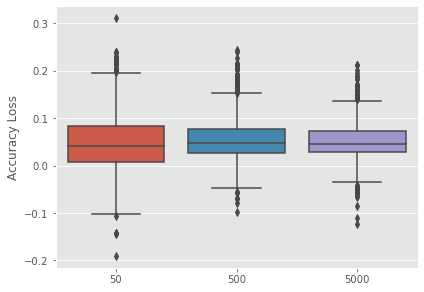

DLCC Accuracy Loss by Size Group in Figure \ref{fig:dlcc-acc-loss-sizegroup}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup.png}}
    \caption{DLCC Accuracy Loss by Size Group}
    \label{fig:dlcc-acc-loss-sizegroup}
\end{figure}


In [11]:
g = sns.catplot(
    data=df_bestscores[df_bestscores["embedding_variant"]!="original-200"], 
    x="Size Group", 
    y="acc_loss",
    kind="box",
    aspect=1.2,
)

g.set_axis_labels("", "Accuracy Loss")
g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle('DLCC Accuracy Loss by Size Group')

plt.savefig("assets/dlcc-acc-loss-sizegroup.png")

plt.show()
    
print("DLCC Accuracy Loss by Size Group in Figure \\ref{fig:dlcc-acc-loss-sizegroup}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup.png}}")
print("    \caption{DLCC Accuracy Loss by Size Group}")
print("    \label{fig:dlcc-acc-loss-sizegroup}")
print("\end{figure}")

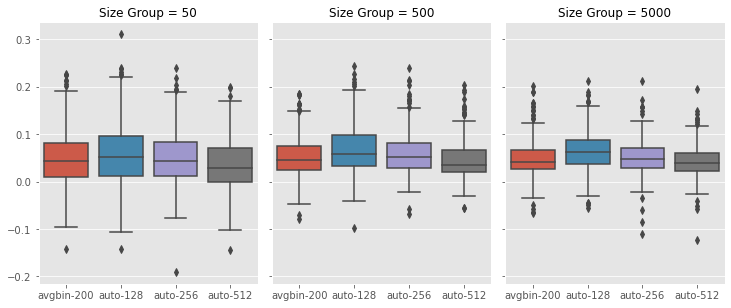

DLCC accuracy loss by size group and embedding variant in Figure \ref{fig:dlcc-acc-loss-sizegroup-variant}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-variant.png}}
    \caption{DLCC Accuracy Loss by Size Group and Embedding Variant}
    \label{fig:dlcc-acc-loss-sizegroup-variant}
\end{figure}


In [12]:
g = sns.catplot(
    data=df_bestscores[df_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="acc_loss",
    kind="box",
    col="Size Group",
    aspect=0.7,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "")
g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle('DLCC Accuracy Loss by Size Group and Embedding Variant.')

plt.savefig("assets/dlcc-acc-loss-sizegroup-variant.png")

plt.show()
    
print("DLCC accuracy loss by size group and embedding variant in Figure \\ref{fig:dlcc-acc-loss-sizegroup-variant}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-variant.png}}")
print("    \caption{DLCC Accuracy Loss by Size Group and Embedding Variant}")
print("    \label{fig:dlcc-acc-loss-sizegroup-variant}")
print("\end{figure}")

In [13]:
def reorganize_latex_table(latex_table):
    latex_table_split = latex_table.split("\n")
    
    latex_table_split[0] += "[h!]"
    caption = latex_table_split.pop(2)
    label = latex_table_split.pop(2)
    end_string = latex_table_split.pop(-1)
    end_table = latex_table_split.pop(-1)

    latex_table_split.extend([caption, label, end_table, end_string])
    return "\n".join(latex_table_split)

In [14]:
def highlight_best_scores(latex_table):
    latex_table_split = latex_table.split("\n")
    highlighted_latex_table_split = []

    for line in latex_table_split:
        line_split = line.strip("\\").split("&")
        if len(line_split) >= 4:
            line_values = []
            for value in line_split:
                if value.strip().replace(".", "").isnumeric():
                    line_values.append(float(value.strip())) 
            if len(line_values) >= 4:
                line_max_value = max(line_values) if max(line_values) > 0 else 1.0
                line_formatted = []
                for value in line_split: 
                    value_numeric = float(value.strip()) if value.strip().replace(".", "").isnumeric() else 0.0
                    new_value = "\t\\textbf{" + value.strip() + "}" if value_numeric==line_max_value else value
                    line_formatted.append(new_value)
                if len(line_formatted)>0:
                    highlighted_latex_table_split.append(" &".join(line_formatted) + " \\" + "\\")
            else:
                highlighted_latex_table_split.append(line)
        else:
                highlighted_latex_table_split.append(line)
    return "\n".join(highlighted_latex_table_split)

In [15]:
emb_types_ordered = [    
    'RDF2vec$_{CBOW}$',
    'RDF2vec$_{CBOW-OA}$', 
    'RDF2vec$_{SG}$', 
    'RDF2vec$_{SG-OA}$', 
    
    'RESCAL',
    'DistMult',
    'ComplEx',
     
    'TransE-L1',
    'TransE-L2',
    'TransR',
    'RotatE',
]

In [22]:
caption="""Count of DLCC classification datasets (out of 60) in which the best classifier 
of each binary embedding variant did not significantly underperfom the original one in accuracy. $\\alpha=0.05$."""

df_sig_not_worst = pd.pivot_table(
    df_bestscores[df_bestscores["embedding_variant"]!="original-200"],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
).loc[emb_types_ordered,:]

df_sig_not_worst_latex = reorganize_latex_table(df_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:dlcc-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))
print(highlight_best_scores(df_sig_not_worst_latex))

print(df_sig_not_worst.mean())

print(df_sig_not_worst.mean(axis=1))

df_sig_not_worst

\begin{table}[h!]
\centering
\label{tab:dlcc-significantly-not-worse}
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{37} &        22  &        27  &        29  \\
RDF2vec$_{CBOW-OA}$  &          33  &        29  &        28  &	\textbf{34} \\
RDF2vec$_{SG}$       &          27  &        22  &        30  &	\textbf{34} \\
RDF2vec$_{SG-OA}$    &          23  &        23  &        25  &	\textbf{27} \\
RESCAL               &          21  &	\textbf{27} &        21  &	\textbf{27} \\
DistMult             &          13  &        17  &        15  &	\textbf{19} \\
ComplEx              &          14  &        18  &        23  &	\textbf{24} \\
TransE-L1            &          22  &        17  &        20  &	\textbf{25} \\
TransE-L2            &          27  &        22  &        26  &	\textbf{31} \\
TransR               &          21  &        20  &        17  &	\textbf{28} \\
RotatE               &          28  &       

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
RDF2vec$_{CBOW}$,22,27,29,37
RDF2vec$_{CBOW-OA}$,29,28,34,33
RDF2vec$_{SG}$,22,30,34,27
RDF2vec$_{SG-OA}$,23,25,27,23
RESCAL,27,21,27,21
DistMult,17,15,19,13
ComplEx,18,23,24,14
TransE-L1,17,20,25,22
TransE-L2,22,26,31,27


In [16]:
def get_latex_table_acc(embedding_type, group_size):
    embedding_type_lower = str.lower(embedding_type).replace("_", "-")
    embedding_type_lower = embedding_type_lower.replace("{", "")
    embedding_type_lower = embedding_type_lower.replace("}", "")
    embedding_type_lower = embedding_type_lower.replace("$", "")
    
    return pd.pivot_table(
        df_bestscores[
            (df_bestscores["embedding_type"]==embedding_type)
            & (df_bestscores["Size Group"]==group_size)
        ], 
        values="AVG Accuracy", 
        index=["TC Collection"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:dlcc-acc-{embedding_type_lower}-{group_size}",
        caption=f"Accuracy scores for best classifier of each embedding variant in each test collection of size {group_size} for {embedding_type} embeddings.",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )

\subsubsection{RDF2vec$_{CBOW}$}
\label{subsubsec:dlcc-results-rdf2vec-cbow} 

DLCC Accuracy Loss (all Size Groups) for RDF2vec$_{CBOW}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-rdf2vec-cbow}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/dlcc-acc-loss-rdf2vec-cbow.png}
    \caption{DLCC Accuracy Loss for RDF2vec$_{CBOW}$ Embeddings}
    \label{fig:dlcc-acc-loss-rdf2vec-cbow}
\end{figure}



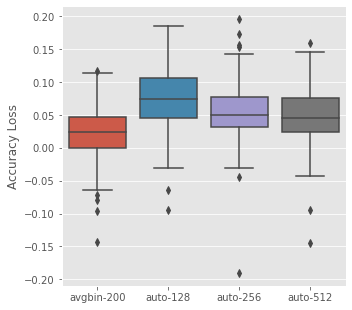

DLCC Accuracy Loss by Size Group for RDF2vec$_{CBOW}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rdf2vec-cbow}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rdf2vec-cbow.png}}
    \caption{DLCC Accuracy Loss by Size Group for RDF2vec$_{CBOW}$ Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rdf2vec-cbow}
\end{figure}


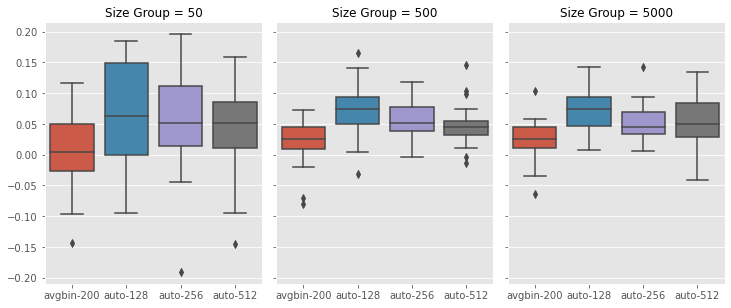

Accuracy scores for RDF2vec$_{CBOW}$ Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rdf2vec-cbow-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.778} &       0.757  &     0.741  &     0.751  &     0.759  \\
tc01-hard  &	\textbf{0.641} &       0.615  &     0.617  &     0.614  &     0.622  \\
tc02       &	\textbf{0.865} &       0.776  &     0.796  &     0.854  &     0.778  \\
tc02-hard  &         0.612  &	\textbf{0.652} &     0.587  &     0.594  &     0.638  \\
tc03       &	\textbf{0.849} &       0.828  &     0.791  &     0.809  &     0.810  \\
tc04       &	\textbf{0.698} &       0.668  &     0.643  &     0.653  &     0.661  \\
tc04-hard  &         0.672  &	\textbf{0.673} &     0.649  &     0.661  &     0.669  \\
tc05       &	\textbf{0.768} &       0.767  &     0.696  &     0.658  &     0.699  \\
tc06       &	\textbf{0.693} &       0.6

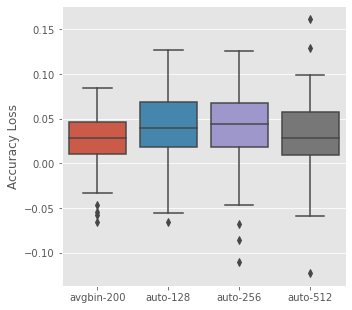

DLCC Accuracy Loss by Size Group for RDF2vec$_{CBOW-OA}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rdf2vec-cbow-oa}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rdf2vec-cbow-oa.png}}
    \caption{DLCC Accuracy Loss by Size Group for RDF2vec$_{CBOW-OA}$ Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rdf2vec-cbow-oa}
\end{figure}


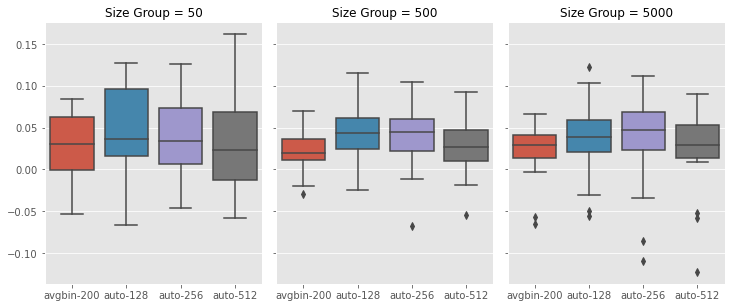

Accuracy scores for RDF2vec$_{CBOW-OA}$ Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rdf2vec-cbow-oa-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.873} &       0.834  &     0.818  &     0.816  &     0.828  \\
tc01-hard  &	\textbf{0.894} &       0.846  &     0.858  &     0.826  &     0.840  \\
tc02       &	\textbf{0.956} &       0.917  &     0.891  &     0.893  &     0.916  \\
tc02-hard  &         0.772  &       0.775  &     0.811  &     0.798  &	\textbf{0.817} \\
tc03       &	\textbf{0.902} &       0.854  &     0.820  &     0.823  &     0.846  \\
tc04       &	\textbf{0.872} &       0.864  &     0.863  &     0.859  &     0.864  \\
tc04-hard  &	\textbf{0.992} &       0.975  &     0.970  &     0.968  &     0.981  \\
tc05       &	\textbf{0.904} &       0.885  &     0.869  &     0.888  &     0.891  \\
tc06       &	\textbf{0.850} &    

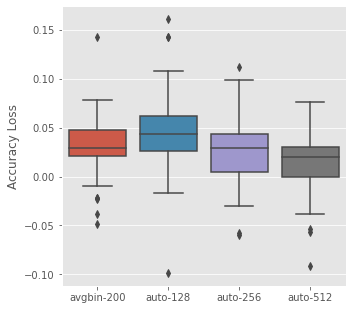

DLCC Accuracy Loss by Size Group for RDF2vec$_{SG}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rdf2vec-sg}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rdf2vec-sg.png}}
    \caption{DLCC Accuracy Loss by Size Group for RDF2vec$_{SG}$ Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rdf2vec-sg}
\end{figure}


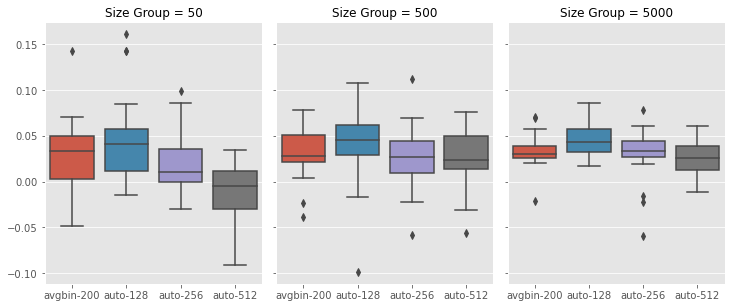

Accuracy scores for RDF2vec$_{SG}$ Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rdf2vec-sg-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.918} &       0.892  &     0.876  &     0.888  &     0.893  \\
tc01-hard  &	\textbf{0.665} &       0.643  &     0.613  &     0.646  &     0.624  \\
tc02       &	\textbf{0.953} &       0.933  &     0.923  &     0.925  &     0.929  \\
tc02-hard  &         0.645  &       0.600  &     0.609  &	\textbf{0.656} &     0.647  \\
tc03       &	\textbf{0.950} &       0.923  &     0.908  &     0.909  &     0.937  \\
tc04       &	\textbf{0.960} &       0.930  &     0.916  &     0.918  &     0.932  \\
tc04-hard  &	\textbf{0.958} &       0.913  &     0.896  &     0.914  &     0.920  \\
tc05       &	\textbf{0.987} &       0.966  &     0.956  &     0.968  &     0.975  \\
tc06       &	\textbf{0.956} &       0.932  

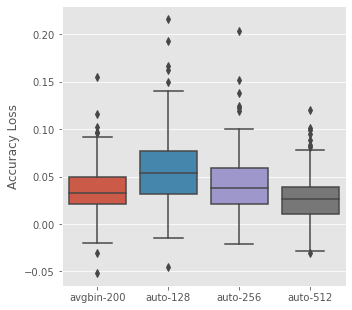

DLCC Accuracy Loss by Size Group for RDF2vec$_{SG-OA}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rdf2vec-sg-oa}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rdf2vec-sg-oa.png}}
    \caption{DLCC Accuracy Loss by Size Group for RDF2vec$_{SG-OA}$ Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rdf2vec-sg-oa}
\end{figure}


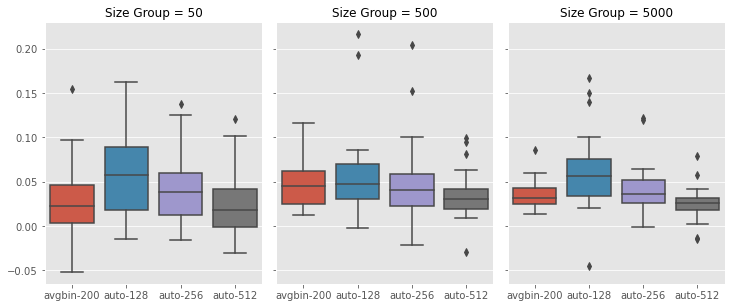

Accuracy scores for RDF2vec$_{SG-OA}$ Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rdf2vec-sg-oa-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.939} &       0.899  &     0.868  &     0.879  &     0.902  \\
tc01-hard  &	\textbf{0.878} &       0.826  &     0.755  &     0.774  &     0.828  \\
tc02       &	\textbf{0.961} &       0.936  &     0.801  &     0.927  &     0.936  \\
tc02-hard  &         0.789  &       0.771  &     0.710  &     0.772  &	\textbf{0.801} \\
tc03       &	\textbf{0.960} &       0.928  &     0.909  &     0.899  &     0.931  \\
tc04       &	\textbf{0.969} &       0.945  &     0.937  &     0.935  &     0.948  \\
tc04-hard  &	\textbf{0.983} &       0.945  &     0.928  &     0.943  &     0.956  \\
tc05       &	\textbf{0.992} &       0.979  &     0.934  &     0.975  &     0.982  \\
tc06       &	\textbf{0.963} &       0

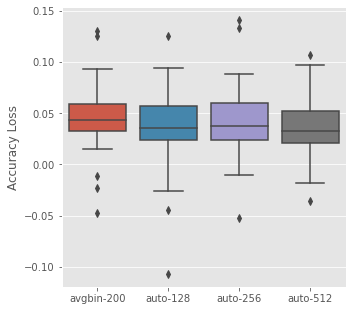

DLCC Accuracy Loss by Size Group for RESCAL Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rescal}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rescal.png}}
    \caption{DLCC Accuracy Loss by Size Group for RESCAL Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rescal}
\end{figure}


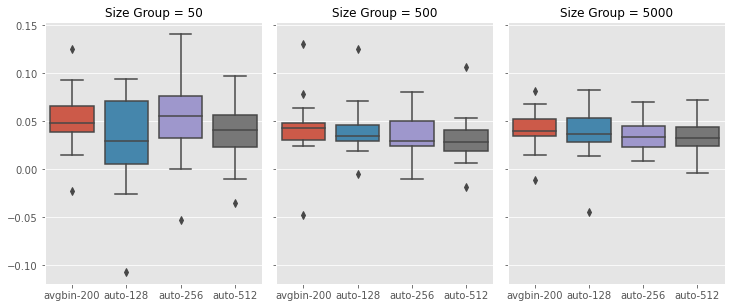

Accuracy scores for RESCAL Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rescal-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.968} &       0.913  &     0.906  &     0.920  &     0.929  \\
tc01-hard  &	\textbf{0.827} &       0.787  &     0.796  &     0.817  &     0.810  \\
tc02       &	\textbf{0.904} &       0.858  &     0.856  &     0.864  &     0.852  \\
tc02-hard  &         0.728  &       0.737  &	\textbf{0.761} &     0.703  &     0.731  \\
tc03       &	\textbf{0.945} &       0.907  &     0.902  &     0.913  &     0.925  \\
tc04       &	\textbf{0.990} &       0.956  &     0.955  &     0.967  &     0.965  \\
tc04-hard  &	\textbf{0.918} &       0.844  &     0.843  &     0.854  &     0.852  \\
tc05       &	\textbf{0.909} &       0.878  &     0.878  &     0.880  &     0.883  \\
tc06       &	\textbf{0.990} &       0.961  &     0.961 

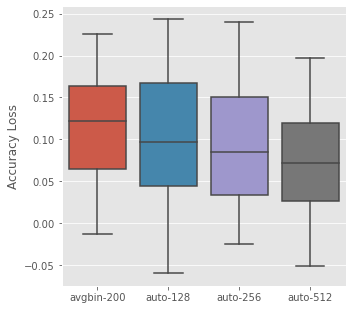

DLCC Accuracy Loss by Size Group for DistMult Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-distmult}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-distmult.png}}
    \caption{DLCC Accuracy Loss by Size Group for DistMult Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-distmult}
\end{figure}


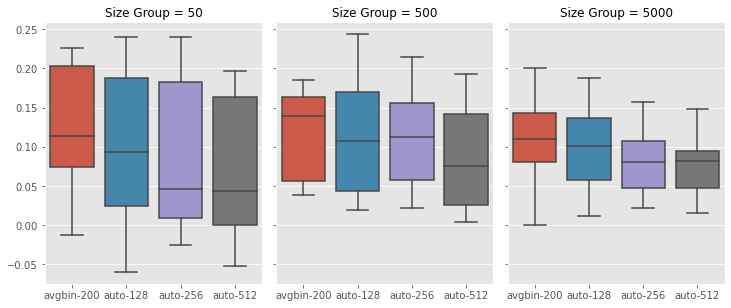

Accuracy scores for DistMult Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-distmult-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.875} &       0.752  &     0.758  &     0.773  &     0.797  \\
tc01-hard  &	\textbf{0.646} &       0.559  &     0.577  &     0.594  &     0.596  \\
tc02       &	\textbf{0.855} &       0.760  &     0.742  &     0.721  &     0.763  \\
tc02-hard  &	\textbf{0.622} &       0.607  &     0.602  &     0.601  &     0.563  \\
tc03       &	\textbf{0.895} &       0.755  &     0.774  &     0.800  &     0.811  \\
tc04       &	\textbf{0.984} &       0.937  &     0.946  &     0.962  &     0.966  \\
tc04-hard  &	\textbf{0.917} &       0.866  &     0.865  &     0.871  &     0.880  \\
tc05       &	\textbf{0.904} &       0.806  &     0.852  &     0.861  &     0.822  \\
tc06       &	\textbf{0.984} &       0.938  &     0.950 

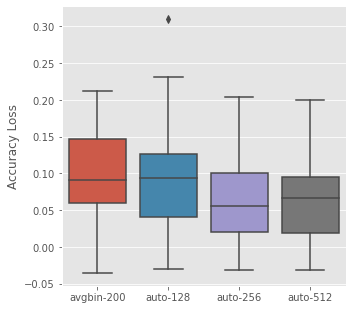

DLCC Accuracy Loss by Size Group for ComplEx Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-complex}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-complex.png}}
    \caption{DLCC Accuracy Loss by Size Group for ComplEx Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-complex}
\end{figure}


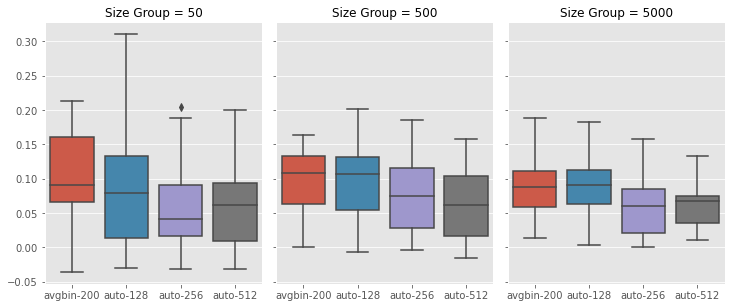

Accuracy scores for ComplEx Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-complex-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.860} &       0.768  &     0.772  &     0.799  &     0.800  \\
tc01-hard  &	\textbf{0.637} &       0.567  &     0.608  &     0.623  &     0.589  \\
tc02       &	\textbf{0.846} &       0.750  &     0.752  &     0.782  &     0.780  \\
tc02-hard  &	\textbf{0.613} &       0.601  &     0.550  &     0.612  &     0.573  \\
tc03       &	\textbf{0.873} &       0.784  &     0.781  &     0.806  &     0.811  \\
tc04       &	\textbf{0.989} &       0.956  &     0.961  &     0.970  &     0.978  \\
tc04-hard  &	\textbf{0.935} &       0.879  &     0.883  &     0.889  &     0.902  \\
tc05       &	\textbf{0.908} &       0.829  &     0.844  &     0.897  &     0.871  \\
tc06       &	\textbf{0.990} &       0.962  &     0.960  &

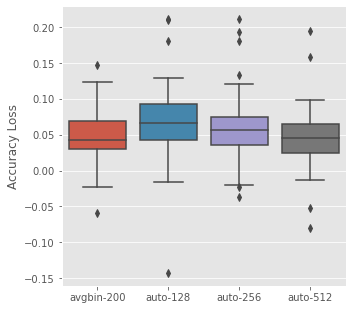

DLCC Accuracy Loss by Size Group for TransE-L1 Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-transe-l1}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-transe-l1.png}}
    \caption{DLCC Accuracy Loss by Size Group for TransE-L1 Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-transe-l1}
\end{figure}


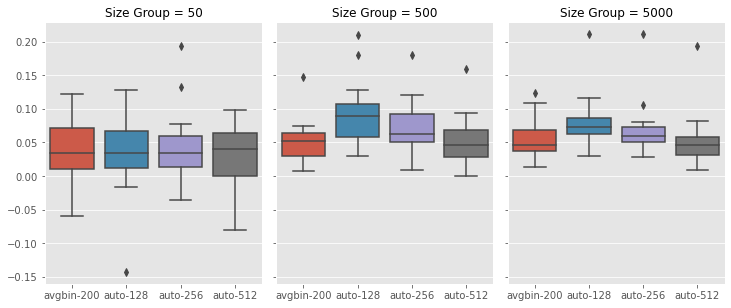

Accuracy scores for TransE-L1 Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-transe-l1-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.842} &       0.794  &     0.778  &     0.788  &     0.797  \\
tc01-hard  &	\textbf{0.799} &       0.712  &     0.709  &     0.754  &     0.743  \\
tc02       &	\textbf{0.855} &       0.816  &     0.791  &     0.801  &     0.813  \\
tc02-hard  &	\textbf{0.778} &       0.725  &     0.698  &     0.742  &     0.752  \\
tc03       &	\textbf{0.823} &       0.786  &     0.774  &     0.772  &     0.777  \\
tc04       &	\textbf{0.932} &       0.903  &     0.872  &     0.878  &     0.896  \\
tc04-hard  &	\textbf{0.820} &       0.760  &     0.725  &     0.733  &     0.758  \\
tc05       &	\textbf{0.868} &       0.834  &     0.817  &     0.820  &     0.798  \\
tc06       &	\textbf{0.928} &       0.891  &     0.84

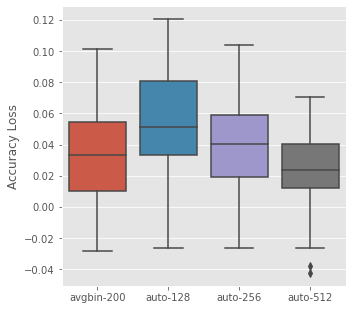

DLCC Accuracy Loss by Size Group for TransE-L2 Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-transe-l2}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-transe-l2.png}}
    \caption{DLCC Accuracy Loss by Size Group for TransE-L2 Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-transe-l2}
\end{figure}


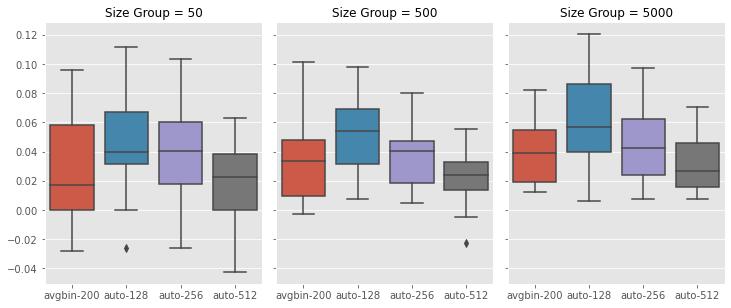

Accuracy scores for TransE-L2 Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-transe-l2-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.947} &       0.896  &     0.871  &     0.899  &     0.911  \\
tc01-hard  &	\textbf{0.917} &       0.880  &     0.837  &     0.845  &     0.875  \\
tc02       &	\textbf{0.972} &       0.929  &     0.886  &     0.914  &     0.938  \\
tc02-hard  &	\textbf{0.871} &       0.838  &     0.777  &     0.807  &     0.820  \\
tc03       &	\textbf{0.933} &       0.880  &     0.854  &     0.869  &     0.883  \\
tc04       &	\textbf{0.987} &       0.969  &     0.950  &     0.964  &     0.974  \\
tc04-hard  &	\textbf{0.911} &       0.837  &     0.802  &     0.823  &     0.847  \\
tc05       &	\textbf{0.947} &       0.916  &     0.906  &     0.915  &     0.919  \\
tc06       &	\textbf{0.984} &       0.965  &     0.94

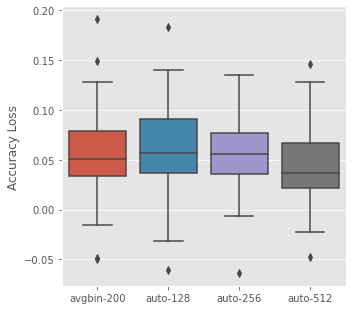

DLCC Accuracy Loss by Size Group for TransR Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-transr}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-transr.png}}
    \caption{DLCC Accuracy Loss by Size Group for TransR Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-transr}
\end{figure}


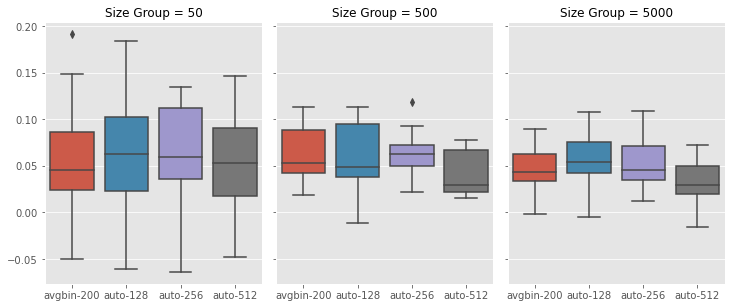

Accuracy scores for TransR Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-transr-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.862} &       0.808  &     0.804  &     0.796  &     0.825  \\
tc01-hard  &	\textbf{0.744} &       0.677  &     0.664  &     0.662  &     0.702  \\
tc02       &	\textbf{0.833} &       0.794  &     0.778  &     0.802  &     0.792  \\
tc02-hard  &         0.693  &       0.692  &     0.625  &     0.684  &	\textbf{0.698} \\
tc03       &	\textbf{0.854} &       0.823  &     0.810  &     0.814  &     0.835  \\
tc04       &	\textbf{0.973} &       0.935  &     0.931  &     0.936  &     0.952  \\
tc04-hard  &	\textbf{0.852} &       0.780  &     0.795  &     0.774  &     0.790  \\
tc05       &	\textbf{0.881} &       0.821  &     0.849  &     0.863  &     0.834  \\
tc06       &	\textbf{0.975} &       0.938  &     0.932 

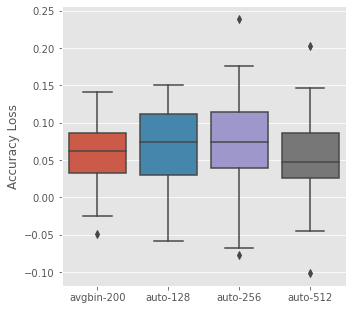

DLCC Accuracy Loss by Size Group for RotatE Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rotate}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rotate.png}}
    \caption{DLCC Accuracy Loss by Size Group for RotatE Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rotate}
\end{figure}


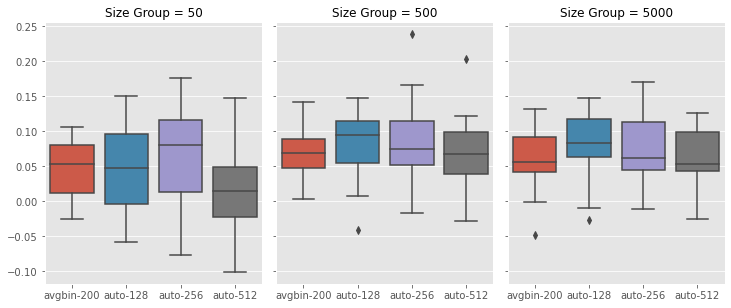

Accuracy scores for RotatE Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rotate-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.768} &       0.674  &     0.670  &     0.680  &     0.678  \\
tc01-hard  &	\textbf{0.618} &       0.570  &     0.551  &     0.598  &     0.590  \\
tc02       &	\textbf{0.712} &       0.704  &     0.694  &     0.698  &     0.688  \\
tc02-hard  &	\textbf{0.649} &       0.564  &     0.565  &     0.538  &     0.568  \\
tc03       &	\textbf{0.780} &       0.705  &     0.700  &     0.692  &     0.704  \\
tc04       &	\textbf{0.862} &       0.827  &     0.795  &     0.813  &     0.817  \\
tc04-hard  &	\textbf{0.789} &       0.737  &     0.693  &     0.707  &     0.726  \\
tc05       &	\textbf{0.802} &       0.729  &     0.733  &     0.706  &     0.705  \\
tc06       &	\textbf{0.866} &       0.819  &     0.791  &  

In [17]:
for embedding_type in emb_types_ordered: 
    embedding_type_lower = str.lower(embedding_type).replace("_", "-")
    embedding_type_lower = embedding_type_lower.replace("{", "")
    embedding_type_lower = embedding_type_lower.replace("}", "")
    embedding_type_lower = embedding_type_lower.replace("$", "")
    
    print("\subsubsection{"+embedding_type+"}")
    print("\label{subsubsec:dlcc-results-"+embedding_type_lower+"} \n")
    
    g = sns.catplot(
        data=df_bestscores[
            (df_bestscores["embedding_variant"]!="original-200")
            & (df_bestscores["embedding_type"]==embedding_type)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "Accuracy Loss")
    g.fig.subplots_adjust(top=0.9)
#     g.fig.suptitle(f'DLCC Accuracy Loss for {embedding_type} embeddings')
    
    plt.savefig(f"assets/dlcc-acc-loss-{embedding_type_lower}.png")
    
    print("DLCC Accuracy Loss (all Size Groups) for "+embedding_type+" Embeddings in Figure \\ref{fig:dlcc-acc-loss-"+embedding_type_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/dlcc-acc-loss-"+embedding_type_lower+".png}")
    print("    \caption{DLCC Accuracy Loss for "+embedding_type+" Embeddings}")
    print("    \label{fig:dlcc-acc-loss-"+embedding_type_lower+"}")
    print("\end{figure}\n")
    
    plt.show()
    
    g = sns.catplot(
        data=df_bestscores[
            (df_bestscores["embedding_variant"]!="original-200")
            & (df_bestscores["embedding_type"]==embedding_type)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        col="Size Group",
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
        aspect=0.7,
    )

    g.set_axis_labels("", "")
    g.fig.subplots_adjust(top=0.85)
#     g.fig.suptitle(f'DLCC Accuracy Loss by Size Group for {embedding_type} Embeddings')
    
    plt.savefig(f"assets/dlcc-acc-loss-sizegroup-{embedding_type_lower}.png")
    
    print("DLCC Accuracy Loss by Size Group for "+embedding_type+" Embeddings in Figure \\ref{fig:dlcc-acc-loss-sizegroup-"+embedding_type_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-"+embedding_type_lower+".png}}")
    print("    \caption{DLCC Accuracy Loss by Size Group for "+embedding_type+" Embeddings}")
    print("    \label{fig:dlcc-acc-loss-sizegroup-"+embedding_type_lower+"}")
    print("\end{figure}")
    
    plt.show()
    
    # for group_size in [50, 500, 5000]:
    group_size=5000
    latex_table_print = highlight_best_scores(
        reorganize_latex_table(
            get_latex_table_acc(embedding_type, group_size)
        )
    )

    print("Accuracy scores for "+embedding_type+" Embeddings in all test collections of size 5000 in table \\ref{tab:dlcc-acc-"+embedding_type_lower+"-5000}.\n\n")

    print(latex_table_print + "\n\n")

In [18]:
def get_latex_table_acc_tc(test_collection, group_size=5000):
    
    return pd.pivot_table(
        df_bestscores[
            (df_bestscores["TC Collection"]==test_collection)
            & (df_bestscores["Size Group"]==group_size)
        ], 
        values="AVG Accuracy", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).loc[emb_types_ordered,:].to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:dlcc-acc-{test_collection}-{group_size}",
        caption=f"Accuracy scores for best classifier of each embedding variant in each test collection {test_collection} of size {group_size}.",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )

DLCC Accuracy Loss (all Size Groups) for Test Collections \{tc01, tc02, tc03\} in Figure \ref{fig:dlcc-acc-loss-tc01-tc02-tc03}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-tc01-tc02-tc03.png}}
    \caption{Relative Accuracy Loss for DLCC Test Collections \{tc01, tc02, tc03\}}
    \label{fig:dlcc-acc-loss-tc01-tc02-tc03}
\end{figure}



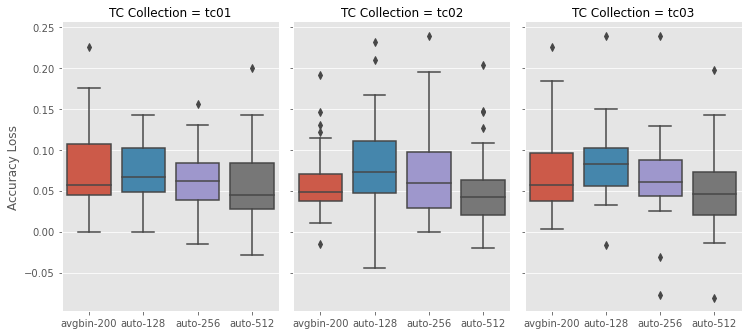

Accuracy scores for test collection tc01 of size 5000 in table \ref{tab:dlcc-acc-tc01-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.778} &       0.757  &     0.741  &     0.751  &     0.759  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.873} &       0.834  &     0.818  &     0.816  &     0.828  \\
RDF2vec$_{SG}$       &	\textbf{0.918} &       0.892  &     0.876  &     0.888  &     0.893  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.939} &       0.899  &     0.868  &     0.879  &     0.902  \\
RESCAL               &	\textbf{0.968} &       0.913  &     0.906  &     0.920  &     0.929  \\
DistMult             &	\textbf{0.875} &       0.752  &     0.758  &     0.773  &     0.797  \\
ComplEx              &	\textbf{0.860} &       0.768  &     0.772  &     0.799  &     0.800  \\
TransE-L1            &	\textbf{0.842} &       0.794  &     0.778  &     0.788  &     0.797  \\
Tr

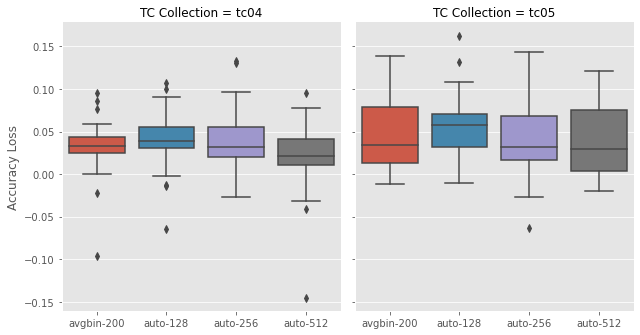

Accuracy scores for test collection tc04 of size 5000 in table \ref{tab:dlcc-acc-tc04-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.698} &       0.668  &     0.643  &     0.653  &     0.661  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.872} &       0.864  &     0.863  &     0.859  &     0.864  \\
RDF2vec$_{SG}$       &	\textbf{0.960} &       0.930  &     0.916  &     0.918  &     0.932  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.969} &       0.945  &     0.937  &     0.935  &     0.948  \\
RESCAL               &	\textbf{0.990} &       0.956  &     0.955  &     0.967  &     0.965  \\
DistMult             &	\textbf{0.984} &       0.937  &     0.946  &     0.962  &     0.966  \\
ComplEx              &	\textbf{0.989} &       0.956  &     0.961  &     0.970  &     0.978  \\
TransE-L1            &	\textbf{0.932} &       0.903  &     0.872  &     0.878  &     0.896  \\
Tr

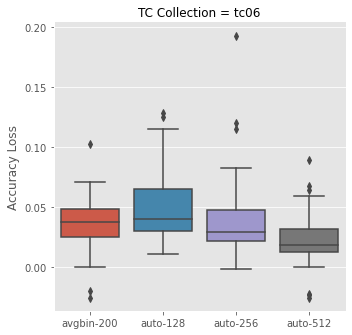

Accuracy scores for test collection tc06 of size 5000 in table \ref{tab:dlcc-acc-tc06-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.693} &       0.659  &     0.636  &     0.645  &     0.648  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.850} &       0.841  &     0.835  &     0.825  &     0.835  \\
RDF2vec$_{SG}$       &	\textbf{0.956} &       0.932  &     0.918  &     0.919  &     0.931  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.963} &       0.938  &     0.930  &     0.931  &     0.937  \\
RESCAL               &	\textbf{0.990} &       0.961  &     0.961  &     0.968  &     0.969  \\
DistMult             &	\textbf{0.984} &       0.938  &     0.950  &     0.958  &     0.968  \\
ComplEx              &	\textbf{0.990} &       0.962  &     0.960  &     0.971  &     0.978  \\
TransE-L1            &	\textbf{0.928} &       0.891  &     0.844  &     0.853  &     0.881  \\
Tr

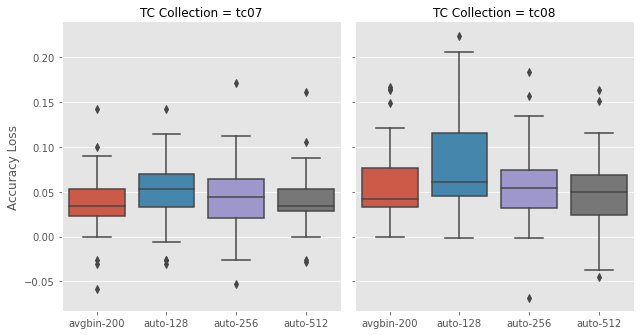

Accuracy scores for test collection tc07 of size 5000 in table \ref{tab:dlcc-acc-tc07-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.746} &       0.734  &     0.707  &     0.715  &     0.709  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.784} &       0.756  &     0.739  &     0.729  &     0.746  \\
RDF2vec$_{SG}$       &	\textbf{0.936} &       0.900  &     0.896  &     0.879  &     0.898  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.953} &       0.920  &     0.921  &     0.892  &     0.922  \\
RESCAL               &	\textbf{0.944} &       0.906  &     0.911  &     0.907  &     0.916  \\
DistMult             &	\textbf{0.932} &       0.847  &     0.842  &     0.887  &     0.900  \\
ComplEx              &	\textbf{0.964} &       0.879  &     0.873  &     0.918  &     0.931  \\
TransE-L1            &	\textbf{0.935} &       0.887  &     0.884  &     0.883  &     0.886  \\
Tr

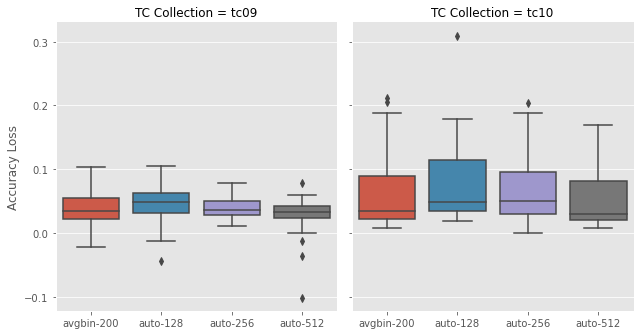

Accuracy scores for test collection tc09 of size 5000 in table \ref{tab:dlcc-acc-tc09-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &	\textbf{0.769} &       0.743  &     0.723  &     0.737  &     0.734  \\
RDF2vec$_{CBOW-OA}$  &	\textbf{0.853} &       0.840  &     0.820  &     0.811  &     0.821  \\
RDF2vec$_{SG}$       &	\textbf{0.898} &       0.865  &     0.869  &     0.867  &     0.874  \\
RDF2vec$_{SG-OA}$    &	\textbf{0.907} &       0.883  &     0.875  &     0.881  &     0.886  \\
RESCAL               &	\textbf{0.922} &       0.881  &     0.877  &     0.889  &     0.889  \\
DistMult             &	\textbf{0.880} &       0.789  &     0.811  &     0.826  &     0.837  \\
ComplEx              &	\textbf{0.887} &       0.817  &     0.827  &     0.849  &     0.858  \\
TransE-L1            &	\textbf{0.884} &       0.850  &     0.828  &     0.854  &     0.861  \\
Tr

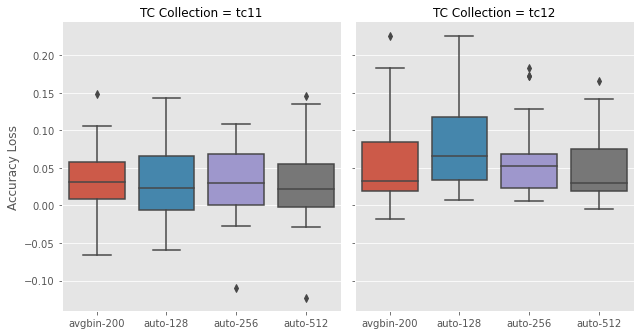

Accuracy scores for test collection tc11 of size 5000 in table \ref{tab:dlcc-acc-tc11-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
RDF2vec$_{CBOW}$     &         0.840  &	\textbf{0.868} &     0.720  &     0.779  &     0.727  \\
RDF2vec$_{CBOW-OA}$  &         0.773  &       0.823  &     0.797  &     0.858  &	\textbf{0.867} \\
RDF2vec$_{SG}$       &         0.954  &       0.974  &     0.891  &	\textbf{0.975} &     0.915  \\
RDF2vec$_{SG-OA}$    &         0.895  &       0.876  &	\textbf{0.935} &     0.896  &     0.885  \\
RESCAL               &	\textbf{0.954} &       0.923  &     0.938  &     0.926  &     0.923  \\
DistMult             &	\textbf{0.854} &       0.772  &     0.787  &     0.771  &     0.805  \\
ComplEx              &	\textbf{0.967} &       0.911  &     0.903  &     0.890  &     0.839  \\
TransE-L1            &	\textbf{0.918} &       0.889  &     0.840  &     0.847  &   

In [19]:
test_collections_types = [
    ['tc01', 'tc02', 'tc03'],
    ['tc04', 'tc05'],
    ['tc06'],
    ['tc07', 'tc08'],
    ['tc09', 'tc10'],
    ['tc11', 'tc12'],
]

for test_collections in test_collections_types:
    test_collections_label = '-'.join(test_collections)
    test_collections_text = ', '.join(test_collections)
    
    if len(test_collections)==3:
        aspect = 0.7
        width = 1.45
    elif len(test_collections)==2:
        aspect = 0.9
        width = 1.15
    else:
        aspect = 1
        width = 0.85

    g = sns.catplot(
        data=df_bestscores[
            (df_bestscores["embedding_variant"]!="original-200")
            & (df_bestscores["TC Collection"].isin(test_collections))
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
        col="TC Collection",
        col_order=test_collections,
        aspect=aspect,
    )

    g.set_axis_labels("", "Accuracy Loss")
    plt.savefig(f"assets/dlcc-acc-loss-{test_collections_label}.png")

    print("DLCC Accuracy Loss (all Size Groups) for Test Collections \{"+test_collections_text+"\} in Figure \\ref{fig:dlcc-acc-loss-"+test_collections_label+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \centerline{\includegraphics[width="+str(width)+"\\linewidth]{assets/dlcc-acc-loss-"+test_collections_label+".png}}")
    print("    \caption{Relative Accuracy Loss for DLCC Test Collections \{"+test_collections_text+"\}}")
    print("    \label{fig:dlcc-acc-loss-"+test_collections_label+"}")
    print("\end{figure}\n")

    plt.show()

    for test_collection in test_collections:
        latex_table_print = highlight_best_scores(
            reorganize_latex_table(
                get_latex_table_acc_tc(test_collection)
            )
        )

        print("Accuracy scores for test collection "+test_collection+" of size 5000 in table \\ref{tab:dlcc-acc-"+test_collection+"-5000}.\n\n")

        print(latex_table_print + "\n\n")

In [20]:
from IPython.display import display

In [21]:
test_collections = [
    'tc01', 'tc02', 'tc03',
    'tc04', 'tc05',
    'tc06',
    'tc07', 'tc08',
    'tc09', 'tc10',
    'tc11', 'tc12',
]
column_order = ["avgbin-200", "auto-128", "auto-256", "auto-512"]

for test_collection in test_collections:
    
    print(test_collection)

    display(pd.pivot_table(
        df_bestscores[
            (df_bestscores["TC Collection"]==test_collection)
            & (df_bestscores["Size Group"]==5000)
            & (df_bestscores["embedding_variant"]!="original-200")
        ], 
        values="not_worse_than_original", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).loc[emb_types_ordered, column_order].style.apply(
        lambda x: ["background: blue" if v else "" for v in x], 
        axis = 1,
    ))

tc01


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc02


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc03


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc04


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc05


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc06


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc07


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc08


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc09


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc10


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc11


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,False,False
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,False,True,False
RDF2vec$_{SG-OA}$,False,True,True,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc12


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,True,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,True
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


In [23]:
test_collections = [
    'tc01', 'tc02', 'tc03',
    'tc04', 'tc05',
    'tc06',
    'tc07', 'tc08',
    'tc09', 'tc10',
    'tc11', 'tc12',
]
column_order = ["avgbin-200", "auto-128", "auto-256", "auto-512"]

for test_collection in test_collections:
    
    print(test_collection)

    display(pd.pivot_table(
        df_bestscores[
            (df_bestscores["TC Collection"]==test_collection)
            & (df_bestscores["Size Group"]==500)
            & (df_bestscores["embedding_variant"]!="original-200")
        ], 
        values="not_worse_than_original", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).loc[emb_types_ordered, column_order].style.apply(
        lambda x: ["background: blue" if v else "" for v in x], 
        axis = 1,
    ))

tc01


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,True,True
RDF2vec$_{CBOW-OA}$,True,False,False,True
RDF2vec$_{SG}$,False,False,False,True
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc02


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,True
RDF2vec$_{SG-OA}$,False,False,False,True
RESCAL,False,False,True,True
DistMult,True,False,False,True
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,True


tc03


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,True
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,True
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc04


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,True
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc05


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,False,True,True
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,True,True,True
DistMult,False,True,False,True
ComplEx,False,True,True,True
TransE-L1,True,False,False,True
TransE-L2,True,False,False,True


tc06


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,False,True,True,True
RDF2vec$_{SG}$,True,False,False,True
RDF2vec$_{SG-OA}$,False,False,True,True
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,True
TransE-L1,False,False,False,False
TransE-L2,False,False,False,False


tc07


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,True,True
RDF2vec$_{CBOW-OA}$,True,True,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,True,True,False
DistMult,False,False,False,True
ComplEx,False,False,False,False
TransE-L1,False,False,False,True
TransE-L2,False,False,True,False


tc08


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,True,False,False,True
RDF2vec$_{SG}$,False,False,True,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,False,False,False,True


tc09


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,True
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,True,False,True
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,True,False,True,False


tc10


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,True,False,False,True
RDF2vec$_{SG}$,False,False,True,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,True,False,False,False


tc11


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,True,True
RDF2vec$_{SG}$,False,False,True,False
RDF2vec$_{SG-OA}$,False,False,False,False
RESCAL,False,False,False,False
DistMult,False,True,False,False
ComplEx,True,True,True,True
TransE-L1,True,False,True,False
TransE-L2,True,True,True,True


tc12


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,False,False,False,False
RDF2vec$_{CBOW-OA}$,False,False,False,False
RDF2vec$_{SG}$,False,False,False,False
RDF2vec$_{SG-OA}$,True,False,False,False
RESCAL,False,False,False,True
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,False,False,False,False
TransE-L2,True,True,True,True


In [24]:
test_collections = [
    'tc01', 'tc02', 'tc03',
    'tc04', 'tc05',
    'tc06',
    'tc07', 'tc08',
    'tc09', 'tc10',
    'tc11', 'tc12',
]
column_order = ["avgbin-200", "auto-128", "auto-256", "auto-512"]

for test_collection in test_collections:
    
    print(test_collection)

    display(pd.pivot_table(
        df_bestscores[
            (df_bestscores["TC Collection"]==test_collection)
            & (df_bestscores["Size Group"]==50)
            & (df_bestscores["embedding_variant"]!="original-200")
        ], 
        values="not_worse_than_original", 
        index=["embedding_type"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).loc[emb_types_ordered, column_order].style.apply(
        lambda x: ["background: blue" if v else "" for v in x], 
        axis = 1,
    ))

tc01


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,False,False,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,False,False,False,False
DistMult,False,True,True,True
ComplEx,False,True,True,False
TransE-L1,True,True,True,True
TransE-L2,True,True,True,True


tc02


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,False,True
RDF2vec$_{CBOW-OA}$,True,False,False,True
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,True,True,True,True
DistMult,True,True,True,True
ComplEx,False,False,True,True
TransE-L1,True,True,True,True
TransE-L2,True,True,True,True


tc03


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,False,True,False
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,True,True,True,True
DistMult,False,False,False,False
ComplEx,False,True,True,True
TransE-L1,True,True,True,True
TransE-L2,True,False,True,True


tc04


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,True,True,True,True
DistMult,False,True,True,True
ComplEx,True,True,True,True
TransE-L1,True,True,False,True
TransE-L2,True,True,True,True


tc05


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,False,True,True
RESCAL,True,True,True,True
DistMult,True,True,True,True
ComplEx,True,True,True,True
TransE-L1,True,True,True,True
TransE-L2,True,True,True,True


tc06


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,True,False,True,True
DistMult,True,True,True,True
ComplEx,False,True,True,True
TransE-L1,True,False,False,True
TransE-L2,False,True,True,True


tc07


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,False
RDF2vec$_{SG}$,False,False,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,True,True,True,True
DistMult,True,False,True,True
ComplEx,True,True,True,True
TransE-L1,True,True,True,True
TransE-L2,True,True,True,True


tc08


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,False,False
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,True,True,True,True
DistMult,False,False,False,False
ComplEx,False,True,True,True
TransE-L1,True,True,True,True
TransE-L2,True,True,True,True


tc09


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,True,True,True,True
DistMult,True,True,True,True
ComplEx,True,False,True,True
TransE-L1,True,True,True,True
TransE-L2,True,True,True,True


tc10


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,False,True,False,True
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,True,True,True,True
TransE-L2,True,True,True,True


tc11


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,True,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,True,True,True,True
DistMult,True,True,True,True
ComplEx,True,True,True,True
TransE-L1,False,False,True,True
TransE-L2,True,False,False,True


tc12


embedding_variant,avgbin-200,auto-128,auto-256,auto-512
embedding_type,,,,
RDF2vec$_{CBOW}$,True,False,True,True
RDF2vec$_{CBOW-OA}$,True,True,True,True
RDF2vec$_{SG}$,True,True,True,True
RDF2vec$_{SG-OA}$,True,True,True,True
RESCAL,True,True,False,True
DistMult,False,False,False,False
ComplEx,False,False,False,False
TransE-L1,True,False,True,False
TransE-L2,True,True,True,True
